In [ ]:
# structure of dataset IEMOCAP
'''
IEMOCAP_full_release/
|------ Documentation/
|      |----- corpus.dic
|      |----- Five_face_markers2.png
|      |----- HumaineInfo.txt
|      |----- phonemes.txt
|      |----- timeinfo.txt
|------ Session1/
|      |---- dialog/
|      |     |---- avi
|      |     |---- EmoEvaluation
|      |     |---- lab
|      |     |---- MOCAP_hand
|      |     |---- MOCAP_head
|      |     |---- MOCAP_rotated
|      |     |---- transcriptions
|      |     |---- wav
|      |---- sentences/
|------ Session2/
|------ Session3/
|------ Session4/
|------ Session5/
|------ README_backup.txt
|------ README.txt
'''


In [2]:
import numpy as np
import pandas as pd
import os
import shutil
import sys
from tqdm import tqdm
import torch
import torchaudio
import torchaudio.transforms as T
import matplotlib.pyplot as plt

## 1. Create file csv

In [7]:
def create_folder(dir_name):
    '''
    Create unexisted folder
    :param dir_name (str): directory to the folder needed to create
    
    return: none
    '''
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)

### 1.1. Combine all audio files from folders sentences

In [8]:
def get_all_data(path):
    '''
    Create a folder including all files sentence audio
    :param path (str): directory to folder dataset
        
    return: none
    '''

    folder_dir = "./IEMOCAP_full_release/wav"
    create_folder(folder_dir)

    for x in range(5):
        ses_name = "Session" + str(x+1)
        path = "./IEMOCAP_full_release/" + ses_name + "/sentences/wav"    #directory to audio file
        for root, _, files in os.walk(path):
            for file_name in files:
                if file_name.endswith(".wav"):
                    file_wav = os.path.join(root,file_name)
                    shutil.copy(file_wav,folder_dir)
                
get_all_data("./IEMOCAP_full_release/")

In [9]:
path = "./IEMOCAP_full_release/wav/"
files = os.listdir(path)
num_files = len(files)
print("Number of file sentences wav: ",num_files)

Number of file sentences wav:  10039


### 1.2. Check mono/stereo, mono -> stereo

### 1.3. Extract MFCCs

In [10]:
def extract_mfcc(path, shape):
    '''
    Extract MFCCs and save into 1 folder
    :param path (str): directory to folder dataset
    :param shape (list): list to store shape of mfccs
    
    return: shape of mfccs
    '''
    files = os.listdir(path)
    folder_dir = "./IEMOCAP_full_release/wav_mfcc"
    create_folder(folder_dir)

    for file in tqdm(files):                  # Initialize tqdm within the loop
        file_path = os.path.join(path, file)
        waveform, sample_rate = torchaudio.load(file_path)
        mfcc_transform = T.MFCC(sample_rate=sample_rate)(waveform)
        file_name = os.path.basename(file).rsplit('.', 1)[0] + '.pt'
        shape.append(mfcc_transform.shape)                 
        torch.save(mfcc_transform, os.path.join(folder_dir, file_name))

    return shape
    
shape = []
shape = extract_mfcc("./IEMOCAP_full_release/wav/", shape)

  0%|          | 0/10039 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
100%|██████████| 10039/10039 [00:20<00:00, 479.04it/s]


In [11]:
shape[0:3]
max(shape)

torch.Size([40, 2732])

### 1.4. Extract Label

In [8]:
def extract_label(lines):
    '''
    Extract name and label from files .txt
    :param lines (str): Lines from files contained label
    
    return: : list of id and labels
    '''

    is_target = True
    id = ''
    label = ''
    labels = []
    for line in lines:
        
        if is_target == True:
            
            try:
                id = line.split('\t')[1].strip()
                label = line.split('\t')[2].strip()
                labels.append([id,label])
                is_target = False
                
            except IndexError as e:
                print("Encountered an IndexError:", e)
                
        else:
            if line == '\n':
                is_target = True
                
    return labels

In [38]:

def get_len(file_path):
    '''
    Get the duration of audios
    :param file_path (str): directory to folder audio
    
    return: list of length of audios
    '''
 
    waveform, sample_rate = torchaudio.load(file_path)
    audio_len = waveform.size(1)/sample_rate
    
    return audio_len
        

In [ ]:
len = []
path = "./IEMOCAP_full_release/wav/"
len = get_len(path,len)
print(len[0:3])
print(max(len), min(len))

### 1.5. Write information to csv

In [39]:
def write_to_csv():
    '''
    Create dataframe including ID, label, length, path
    
    return: data
    '''
    
    labels = []
    data = []
    
    for x in range(5):
        sess_name = "Session" + str(x+1)
        files_dir = "./IEMOCAP_full_release/" + sess_name + "/dialog/EmoEvaluation"
        
        for _, folder, files in os.walk(files_dir):
            for fol in folder:
                folder_path = os.path.join(files_dir,fol)
                shutil.rmtree(folder_path)
                
            for file_name in files:
                full_path = os.path.join(files_dir,file_name)
                
                if file_name.endswith('.txt'):
                    with open(full_path,'r') as read_lines:
                        lines = read_lines.readlines()
                        lines = lines[2:]
                        labels = (extract_label(lines))
                        
                for label in labels:       
                    dir = "./IEMOCAP_full_release/wav/"
                    file_path = os.path.join(dir,label[0] + ".wav")     
                    len =  get_len(file_path)
                    data.append({
                        "ID": label[0],
                        "label": label[1],
                        "length": len,
                        "path": file_path
                })
            
    data = pd.DataFrame(data)

    return data
    

In [ ]:
data = write_to_csv()
data.to_csv('processed_label_data.csv', index = False)

### 1.6. Split training vavid dataset

In [ ]:
def split

# 2. EDA

In [3]:
data = pd.read_csv("processed_label_data.csv")
data.head(10)

,ID,label,length,path
0,Ses01M_impro01_F000,ang,1.689938,./IEMOCAP_full_release/wav/Ses01M_impro01_F000...
1,Ses01M_impro01_F001,ang,2.050000,./IEMOCAP_full_release/wav/Ses01M_impro01_F001...
2,Ses01M_impro01_F002,xxx,3.769938,./IEMOCAP_full_release/wav/Ses01M_impro01_F002...
3,Ses01M_impro01_F003,xxx,3.949937,./IEMOCAP_full_release/wav/Ses01M_impro01_F003...
4,Ses01M_impro01_F004,fru,3.037500,./IEMOCAP_full_release/wav/Ses01M_impro01_F004...
5,Ses01M_impro01_F005,xxx,2.550000,./IEMOCAP_full_release/wav/Ses01M_impro01_F005...
6,Ses01M_impro01_F006,xxx,2.449937,./IEMOCAP_full_release/wav/Ses01M_impro01_F006...
7,Ses01M_impro01_F007,ang,3.419938,./IEMOCAP_full_release/wav/Ses01M_impro01_F007...
8,Ses01M_impro01_F008,ang,3.736000,./IEMOCAP_full_release/wav/Ses01M_impro01_F008...
9,Ses01M_impro01_F009,xxx,2.779937,./IEMOCAP_full_release/wav/Ses01M_impro01_F009...


In [6]:
data['ID'].describe()

count                   10039
unique                  10039
top       Ses01M_impro01_F000
freq                        1
Name: ID, dtype: object

In [6]:
data["label"].value_counts()

label
xxx    2507
fru    1849
neu    1708
ang    1103
sad    1084
exc    1041
hap     595
sur     107
fea      40
oth       3
dis       2
Name: count, dtype: int64

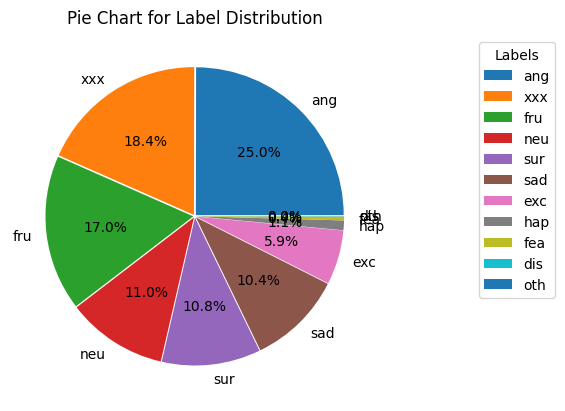

In [4]:
labels = data['label'].unique()
percentage = data['label'].value_counts(normalize=True) * 100
percentage_list = percentage.tolist()
explode = [0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01]

plt.pie(percentage, labels=labels,explode=explode,autopct='%1.1f%%')
plt.legend(title ="Labels",
          loc ="center left",
          bbox_to_anchor =(1.25, 0, 0.5, 1.25))

plt.title('Pie Chart for Label Distribution')
plt.show()

- To serve the purpose of the problem and to simplify, the emotional labels can be merged into 3 main types: neutral, positive, negative
- The labels 'xxx' and 'other' will be removed to avoid confusion

In [8]:
data['label'] = data['label'].replace({'fru': 'neutral', 
                                    'exc': 'positive', 
                                    'hap': 'positive', 
                                    'sur': 'positive',
                                    'fea': 'negative', 
                                    'ang': 'negative', 
                                    'sad': 'negative', 
                                    'dis': 'negative'})

data = data[~data['label'].isin(['xxx', 'oth'])]

In [9]:
data.head(10)

,ID,label,length,path
0,Ses01M_impro01_F000,negative,1.689938,./IEMOCAP_full_release/wav/Ses01M_impro01_F000...
1,Ses01M_impro01_F001,negative,2.050000,./IEMOCAP_full_release/wav/Ses01M_impro01_F001...
4,Ses01M_impro01_F004,neu,3.037500,./IEMOCAP_full_release/wav/Ses01M_impro01_F004...
7,Ses01M_impro01_F007,negative,3.419938,./IEMOCAP_full_release/wav/Ses01M_impro01_F007...
8,Ses01M_impro01_F008,negative,3.736000,./IEMOCAP_full_release/wav/Ses01M_impro01_F008...
10,Ses01M_impro01_F010,neu,2.019938,./IEMOCAP_full_release/wav/Ses01M_impro01_F010...
11,Ses01M_impro01_F011,negative,2.159937,./IEMOCAP_full_release/wav/Ses01M_impro01_F011...
12,Ses01M_impro01_F012,negative,1.925000,./IEMOCAP_full_release/wav/Ses01M_impro01_F012...
15,Ses01M_impro01_F015,neu,6.009938,./IEMOCAP_full_release/wav/Ses01M_impro01_F015...
19,Ses01M_impro01_F019,negative,3.610000,./IEMOCAP_full_release/wav/Ses01M_impro01_F019...


In [10]:
data["ID"].describe()

count                    7529
unique                   7529
top       Ses01M_impro01_F000
freq                        1
Name: ID, dtype: object

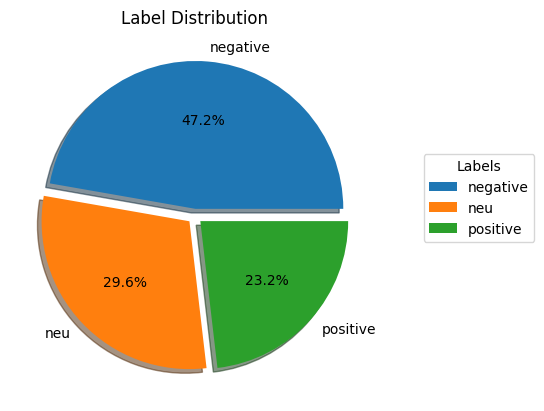

In [11]:
labels = data['label'].unique()
percentage = data['label'].value_counts(normalize=True) * 100
percentage_list = percentage.tolist()
explode = [0.05,0.05,0.05]

plt.pie(percentage, labels=labels,explode=explode,shadow=True,autopct='%1.1f%%')
plt.legend(title ="Labels",
          loc ="center left",
          bbox_to_anchor =(1.1, 0, 0.5, 1.1))

plt.title('Label Distribution')
plt.show()

After combining and spliting into 3 main labels: 'negative', 'positive' and 'neutral', there is a slight bias towards the 'negative' label. 'negative' counts for nearly half of data so we choose some data augmentation techniques for labels to achieve a more balanced dataset and be nearly similar to real data before beginning the training process.

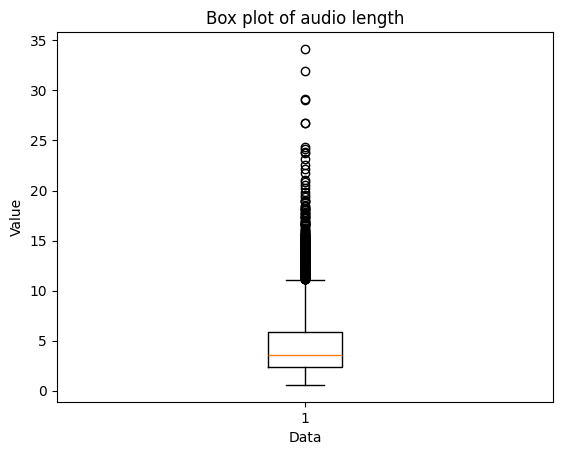

In [63]:
len = data["length"]
fig, ax = plt.subplots()

ax.boxplot(len)

ax.set_title('Box plot of audio length')
ax.set_xlabel('Data')
ax.set_ylabel('Value')
plt.show()

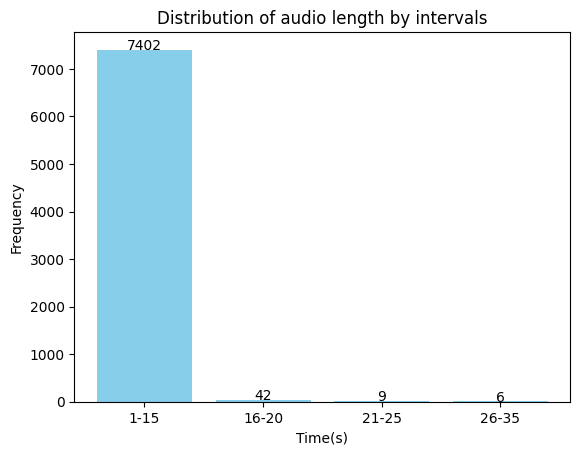

In [64]:
len = data["length"]
ranges = [(1, 15), (16, 20), (21, 25), (26, 35)]

# Create a list to store counts in each range
counts = [0] * 4

for num in len:
    for i, (start, end) in enumerate(ranges):
        if start <= num <= end:
            counts[i] += 1

plt.bar([f"{r[0]}-{r[1]}" for r in ranges], counts, color='skyblue')

for i, (start, end) in enumerate(ranges):
    plt.text(i,counts[i] + 1, str(counts[i]), ha = "center")

plt.xlabel("Time")   
plt.ylabel('Frequency')
plt.title('Distribution of audio length by intervals')
plt.show()

torch.Size([1, 27039])


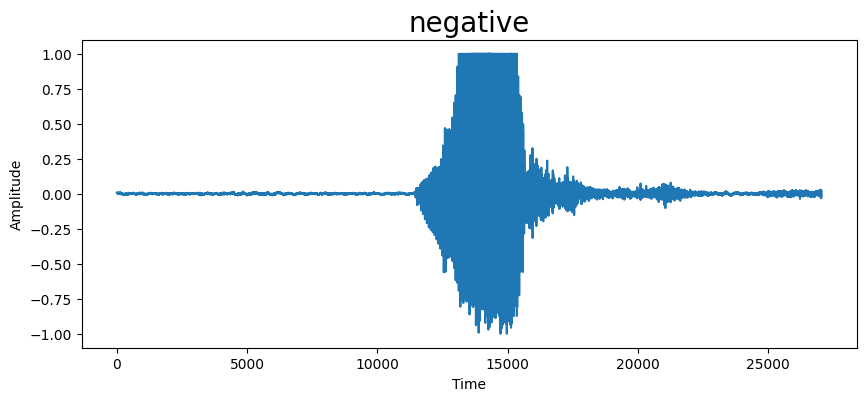

torch.Size([1, 50079])


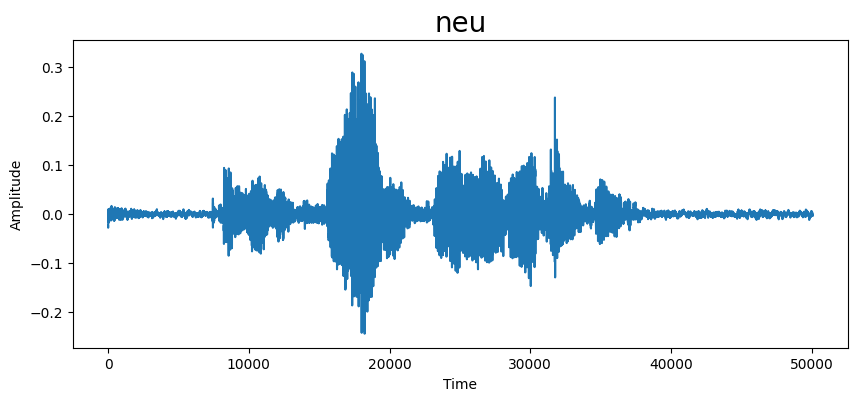

torch.Size([1, 70760])


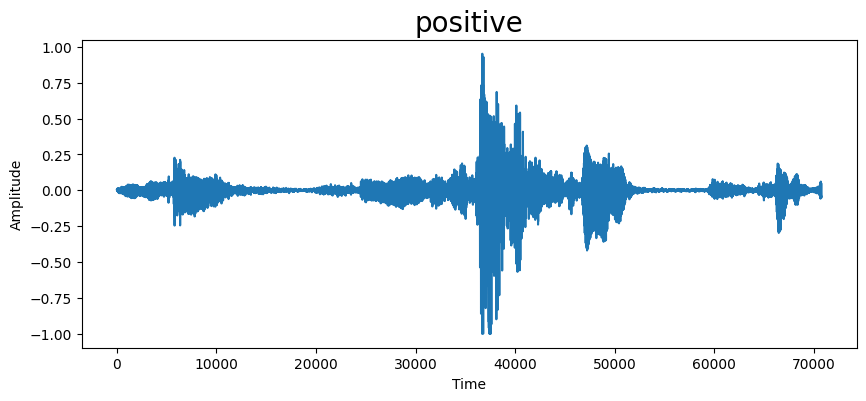

In [22]:
dir_index = [0, 36, 129]
for index in dir_index:
    dir_path = data['path'][index]
    waveform, sr = torchaudio.load(dir_path)
    print(waveform.shape)
    plt.figure(figsize=(10, 4))
    plt.title(data['label'][index], size=20)
    plt.plot(waveform.numpy().T)
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.show()

Negative emotion state is often accompanied by a significant sudden increase in the frequency of the sound.

Neutral emotion state usually produces sounds with moderate frequency, neither too high nor too low.

Positive emotion state often generates sounds with high and extended frequencies compared to the other states.

(1, 40, 274)


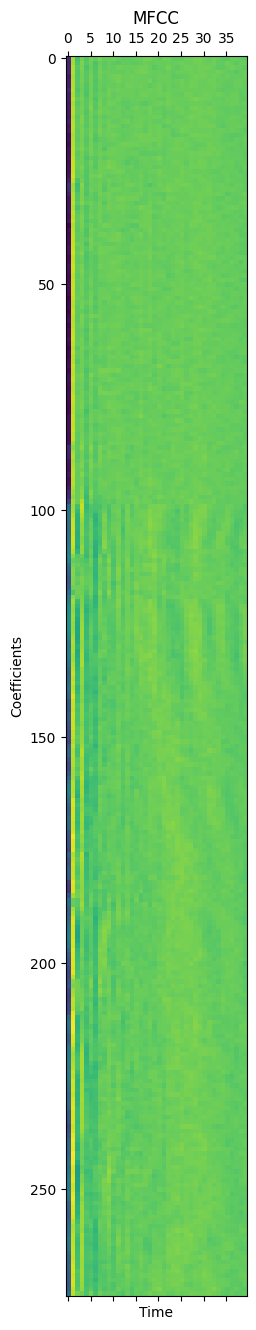

In [24]:
mfccs = torch.load('./IEMOCAP_full_release/wav_mfcc/Ses01F_impro01_F004.pt')
mfccs = mfccs.numpy() 
print(mfccs.shape)

plt.matshow(mfccs.T)
plt.title('MFCC')
plt.ylabel('Coefficients') 
plt.xlabel('Time')
plt.show()

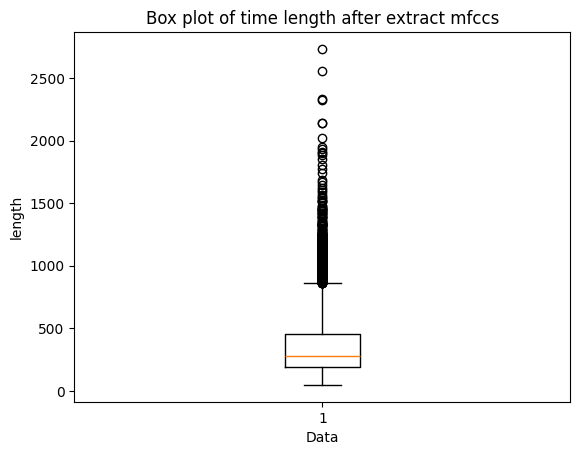

In [36]:
path = "./IEMOCAP_full_release/wav_mfcc/"
mfcc_dir_list = os.listdir(path)
time = []
for mfcc_dir in mfcc_dir_list:
    full_mfcc_dir = os.path.join(path,mfcc_dir)
    mfccs = torch.load(full_mfcc_dir)
    mfccs = mfccs.numpy() 
    time.append(mfccs.shape[2])    

fig, ax = plt.subplots()
ax.boxplot(time)

ax.set_title('Box plot of time length after extract mfccs')
ax.set_xlabel('Data')
ax.set_ylabel('length')
plt.show()

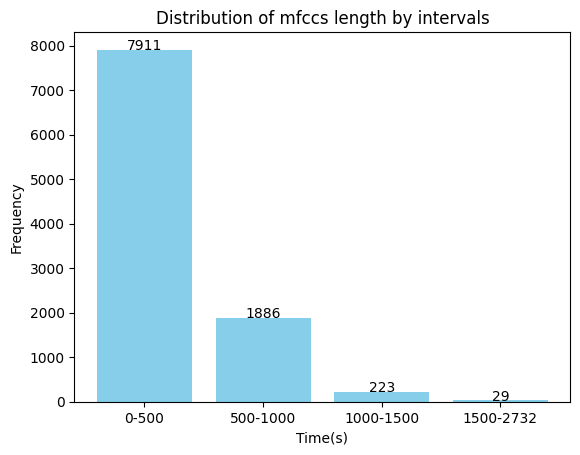

In [37]:
ranges = [(0,500), (500,1000), (1000, 1500), (1500, max(time))]

# Create a list to store counts in each range
counts = [0] * 4

for num in time:
    for i, (start, end) in enumerate(ranges):
        if start <= num <= end:
            counts[i] += 1

plt.bar([f"{r[0]}-{r[1]}" for r in ranges], counts, color='skyblue')

for i, (start, end) in enumerate(ranges):
    plt.text(i,counts[i] + 1, str(counts[i]), ha = "center")

plt.xlabel("Timeshape")   
plt.ylabel('Frequency')
plt.title('Distribution of timeshape by intervals')
plt.show()

The distribution of timeshape 0-900 frames counts for most of data, so we choose the the max timeshape is 900, remove all the outliner